In [1]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image
from torchvision import transforms as tfms
from moviepy.editor import ImageSequenceClip
import numpy as np

/mnt/disks/main/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# utils
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

def create_video(images, fps=24, output_path=None):
    image_sequence = [np.array(img) for img in images]
    clip = ImageSequenceClip(image_sequence, fps=fps)
    if output_path is not None:
        print(output_path)
        clip.write_videofile(output_path, codec="libx264")
    return clip


In [3]:
controlnet = ControlNetModel.from_pretrained('takuma104/control_v11', 
                                             subfolder='control_v11f1e_sd15_tile',
                                             torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    custom_pipeline="invertible_controlnet_img2img",
    controlnet=controlnet,
    torch_dtype=torch.float16).to('cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

# compile seems not working
# pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
# pipe.controlnet = torch.compile(pipe.controlnet, mode="reduce-overhead", fullgraph=True)

pipe.safety_checker = None

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [44]:
frame_1 = load_image('./data/woman_dance_in_street/040.png')
frame_2 = load_image('./data/woman_dance_in_street/050.png')

In [45]:
def invert(
        image, 
        num_inference_steps
    ):
    with torch.no_grad(): latent = pipe.vae.encode((tfms.functional.to_tensor(image).unsqueeze(0).to('cuda')*2-1).half())
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = pipe.invert(
        l, 
        prompt="", 
        negative_prompt="",
        guidance_scale=3.5, 
        num_inference_steps=num_inference_steps
    )
    return inverted_latents
def interpolate(inverted_latents, frame_2, cn_scale, start_step, num_inference_steps, cn_end):
    image = pipe(
        prompt="", 
        negative_prompt="",
        image=frame_2, 
        controlnet_conditioning_image=frame_2, 
        width=frame_2.size[0],
        height=frame_2.size[1],
        strength=1, 
        generator=torch.manual_seed(0),
        num_inference_steps=num_inference_steps, 
        guidance_scale=3.5, 
        controlnet_guidance_end=cn_end,
        controlnet_conditioning_scale=cn_scale,
        latents= inverted_latents[-(start_step + 1)][None],
        start_step=start_step,
    ).images[0]
    return image

In [46]:
num_inference_steps = 300

In [40]:
torch._dynamo.config.suppress_errors = True
inverted_latents = invert(frame_1, num_inference_steps)

  0%|          | 0/299 [00:00<?, ?it/s]

100%|█████████▉| 298/299 [00:47<00:00,  6.25it/s]


In [31]:
start_step = 0

0 0.0


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [01:02<00:00,  4.79it/s]


1 0.01


100%|██████████| 300/300 [01:01<00:00,  4.88it/s]


2 0.05


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


3 0.1


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


4 0.2


100%|██████████| 300/300 [01:01<00:00,  4.84it/s]


5 0.3


100%|██████████| 300/300 [01:01<00:00,  4.86it/s]


6 0.4


100%|██████████| 300/300 [01:02<00:00,  4.83it/s]


7 0.6


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


8 0.7


100%|██████████| 300/300 [01:01<00:00,  4.86it/s]


9 0.8


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


10 1.0


100%|██████████| 300/300 [01:01<00:00,  4.84it/s]


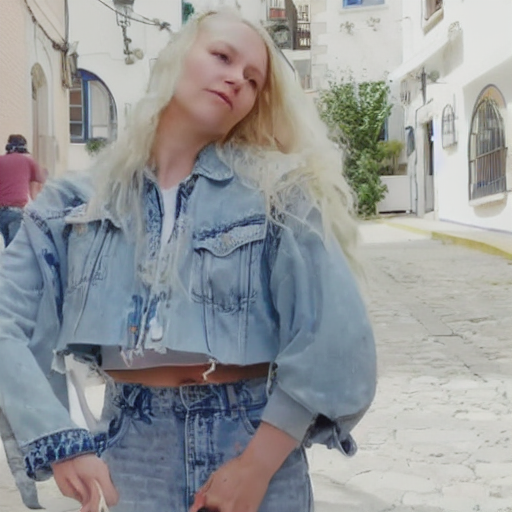

In [48]:
cn_scale_list = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7,0.8, 1.0] # my intuition
# cn_scale_list = [0.5]

images = []
for i, cn_scale in enumerate(cn_scale_list):
    print(i, cn_scale)
    img = interpolate(inverted_latents, frame_2, cn_scale, start_step, num_inference_steps, cn_end=0.8)
    images.append(img)
    img.save(f"./data/woman_dance_in_street_40-50/{i}.png")
images[0]

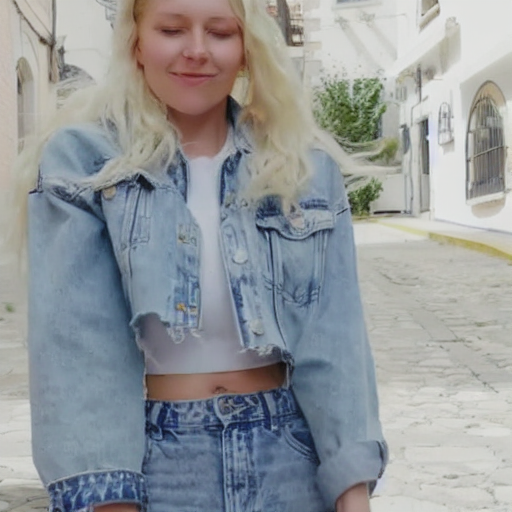

In [24]:
images[9]

In [19]:
create_video(images, fps=5).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   0%|          | 0/10 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [36]:
from glob import glob
save_dir = "./data/woman_dance_in_street_cn_end_1"
file_paths = sorted(glob("./data/woman_dance_in_street/*"))
interpolate_step = 10
cn_scale_list = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 1.0] # my intuition
num_inference_steps = 300
start_step = 0
cn_end = 0.8

assert interpolate_step == len(cn_scale_list)
for i in range(len(file_paths)):
    if i < 25: # delete it
        continue

    if i % interpolate_step == 0:
        if i == 0:
            continue

        frame_1 = load_image(file_paths[i-interpolate_step])
        frame_2 = load_image(file_paths[i])

        inverted_latents = invert(frame_1, num_inference_steps)
        for f, cn_scale in enumerate(cn_scale_list):
            print(f, cn_scale)
            
            save_path = f"{save_dir}/{'{:03}'.format(i - interpolate_step + f + 1)}.png"
            interpolated_frame = interpolate(
                inverted_latents, 
                frame_2, 
                cn_scale, 
                start_step, 
                num_inference_steps, 
                cn_end,
            )
            interpolated_frame.save(save_path)


100%|█████████▉| 298/299 [00:47<00:00,  6.27it/s]


0 0.0


100%|██████████| 300/300 [01:01<00:00,  4.86it/s]


1 0.01


100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


2 0.05


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


3 0.1


100%|██████████| 300/300 [01:01<00:00,  4.84it/s]


4 0.2


100%|██████████| 300/300 [01:02<00:00,  4.83it/s]


5 0.3


100%|██████████| 300/300 [01:02<00:00,  4.83it/s]


6 0.4


100%|██████████| 300/300 [01:01<00:00,  4.84it/s]


7 0.6


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


8 0.7


100%|██████████| 300/300 [01:02<00:00,  4.83it/s]


9 1.0


100%|█████████▉| 298/299 [00:46<00:00,  6.35it/s]


0 0.0


100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


1 0.01


100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


2 0.05


100%|██████████| 300/300 [01:02<00:00,  4.83it/s]


3 0.1


100%|██████████| 300/300 [01:02<00:00,  4.83it/s]


4 0.2


100%|██████████| 300/300 [01:01<00:00,  4.84it/s]


5 0.3


100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


6 0.4


100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


7 0.6


100%|██████████| 300/300 [01:02<00:00,  4.84it/s]


8 0.7


100%|██████████| 300/300 [01:02<00:00,  4.84it/s]


9 1.0


100%|█████████▉| 298/299 [00:46<00:00,  6.37it/s]


0 0.0


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


1 0.01


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


2 0.05


100%|██████████| 300/300 [01:02<00:00,  4.84it/s]


3 0.1


100%|██████████| 300/300 [01:02<00:00,  4.81it/s]


4 0.2


100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


5 0.3


100%|██████████| 300/300 [01:02<00:00,  4.82it/s]


6 0.4


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


7 0.6


100%|██████████| 300/300 [01:02<00:00,  4.83it/s]


8 0.7


100%|██████████| 300/300 [01:01<00:00,  4.84it/s]


9 1.0


100%|█████████▉| 298/299 [00:46<00:00,  6.37it/s]


0 0.0


100%|██████████| 300/300 [01:01<00:00,  4.84it/s]


1 0.01


100%|██████████| 300/300 [01:01<00:00,  4.85it/s]


2 0.05


100%|██████████| 300/300 [01:02<00:00,  4.84it/s]


3 0.1


 83%|████████▎ | 249/300 [00:53<00:11,  4.62it/s]


KeyboardInterrupt: 

In [53]:
images_total = [frame_1] + images + [frame_2]
create_video(images_total, fps=5).write_videofile('./sample_output.mp4')

Moviepy - Building video ./sample_output.mp4.
Moviepy - Writing video ./sample_output.mp4



Moviepy - Done !
Moviepy - video ready ./sample_output.mp4
